In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import io
import torch 
import time
import numpy as np
from collections import OrderedDict

%pylab inline
rcParams["figure.figsize"] = (16,5)
sys.path.append('/home/erogol/projects/')

import librosa
import librosa.display

from torchviz import make_dot, make_dot_from_trace

from TTS.models.tacotron import Tacotron 
from TTS.layers import *
from TTS.utils.data import *
from TTS.utils.audio import AudioProcessor
from TTS.utils.generic_utils import load_config
from TTS.utils.text import text_to_sequence

import IPython
from IPython.display import Audio
from utils import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
def tts(model, text, CONFIG, use_cuda, ap, figures=True):
    t_1 = time.time()
    waveform, alignment, spectrogram = create_speech(model, text, CONFIG, use_cuda, ap) 
    print(" >  Run-time: {}".format(time.time() - t_1))
    if figures:                                                                                                         
        visualize(alignment, spectrogram, CONFIG)                                                                       
    IPython.display.display(Audio(waveform, rate=CONFIG.sample_rate))  
    return alignment, spectrogram

In [3]:
# Set constants
ROOT_PATH = '/data/shared/erogol_models/April-12-2018_06:00AM-06d4b23/'
MODEL_PATH = ROOT_PATH + '/checkpoint_118440.pth.tar'
CONFIG_PATH = ROOT_PATH + '/config.json'
OUT_FOLDER = ROOT_PATH + '/test/'
CONFIG = load_config(CONFIG_PATH)
use_cuda = False

In [4]:
# load the model
model = Tacotron(CONFIG.embedding_size, CONFIG.num_freq, CONFIG.num_mels, CONFIG.r)

# load the audio processor
ap = AudioProcessor(CONFIG.sample_rate, CONFIG.num_mels, CONFIG.min_level_db,
                    CONFIG.frame_shift_ms, CONFIG.frame_length_ms, CONFIG.preemphasis,
                    CONFIG.ref_level_db, CONFIG.num_freq, CONFIG.power, griffin_lim_iters=80)         


# load model state
if use_cuda:
    cp = torch.load(MODEL_PATH)
else:
    cp = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)

# load the model
model.load_state_dict(cp['model'])
if use_cuda:
    model.cuda()
model.eval()

 | > Number of characted : 149


Tacotron(
  (embedding): Embedding(149, 256)
  (encoder): Encoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): Linear(in_features=256, out_features=256)
        (1): Linear(in_features=256, out_features=128)
      )
      (relu): ReLU()
      (dropout): Dropout(p=0.5)
    )
    (cbhg): CBHG(
      (relu): ReLU()
      (conv1d_banks): ModuleList(
        (0): BatchNormConv1d(
          (conv1d): Conv1d (128, 128, kernel_size=(1,), stride=(1,), bias=False)
          (bn): BatchNorm1d(128, eps=0.001, momentum=0.99, affine=True)
          (activation): ReLU()
        )
        (1): BatchNormConv1d(
          (conv1d): Conv1d (128, 128, kernel_size=(2,), stride=(1,), padding=(1,), bias=False)
          (bn): BatchNorm1d(128, eps=0.001, momentum=0.99, affine=True)
          (activation): ReLU()
        )
        (2): BatchNormConv1d(
          (conv1d): Conv1d (128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (bn): BatchNorm1d(128, eps=0.001, mo

### EXAMPLES FROM TRAINING SET

In [5]:
import pandas as pd
df = pd.read_csv('/data/shared/KeithIto/LJSpeech-1.0/metadata_val.csv', delimiter='|')

Latona's findings were also confirmed by Ronald G. Wittmus, another FBI fingerprint expert.
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch.Size([1, 400])
torch

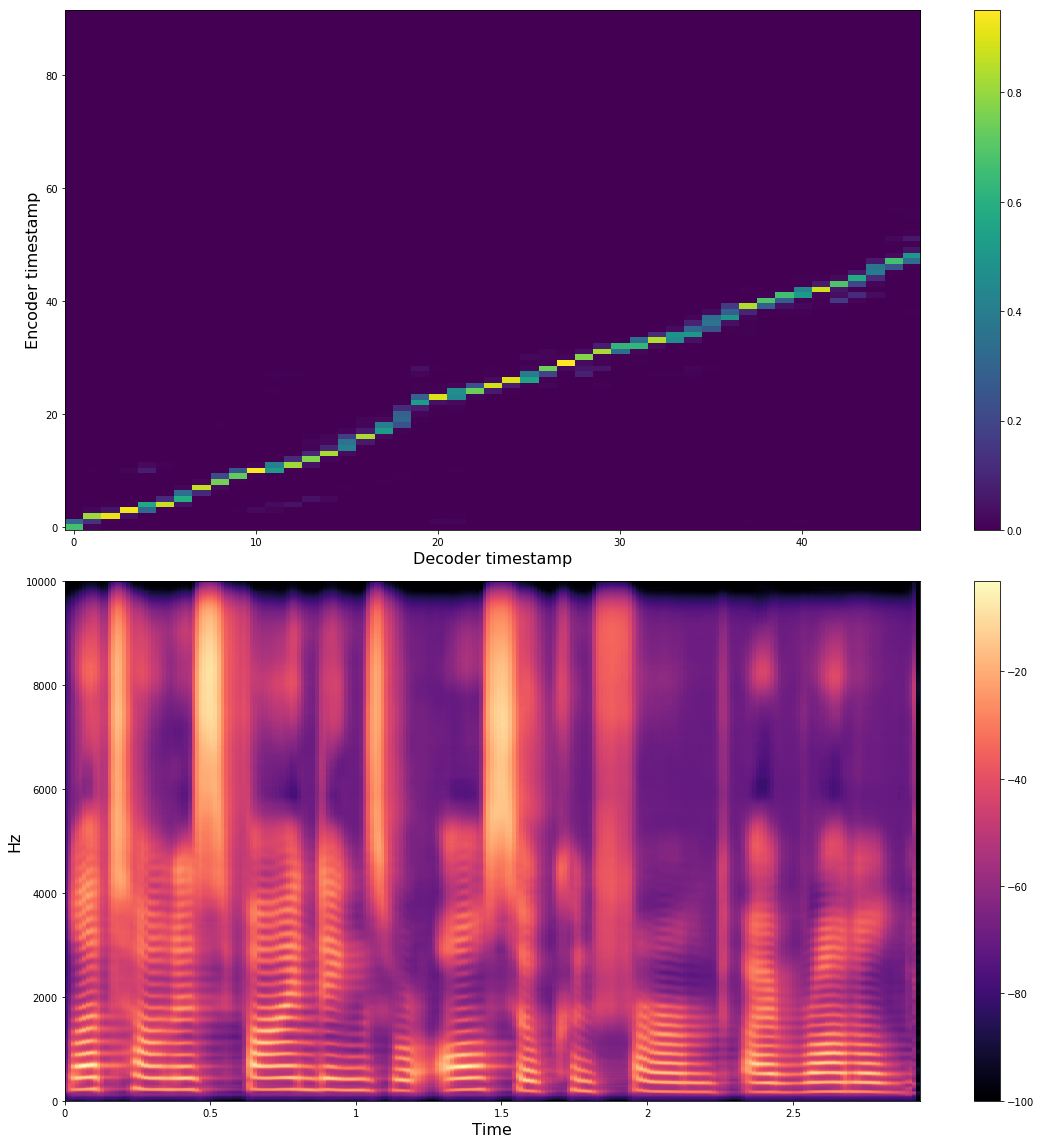

In [6]:
sentence = df.iloc[2, 1]
print(sentence)
model.decoder.max_decoder_steps = len(sentence)
align, spec = tts(model, sentence, CONFIG, use_cuda, ap)

### Comparision with https://mycroft.ai/blog/available-voices/

 >  Run-time: 17.50665545463562


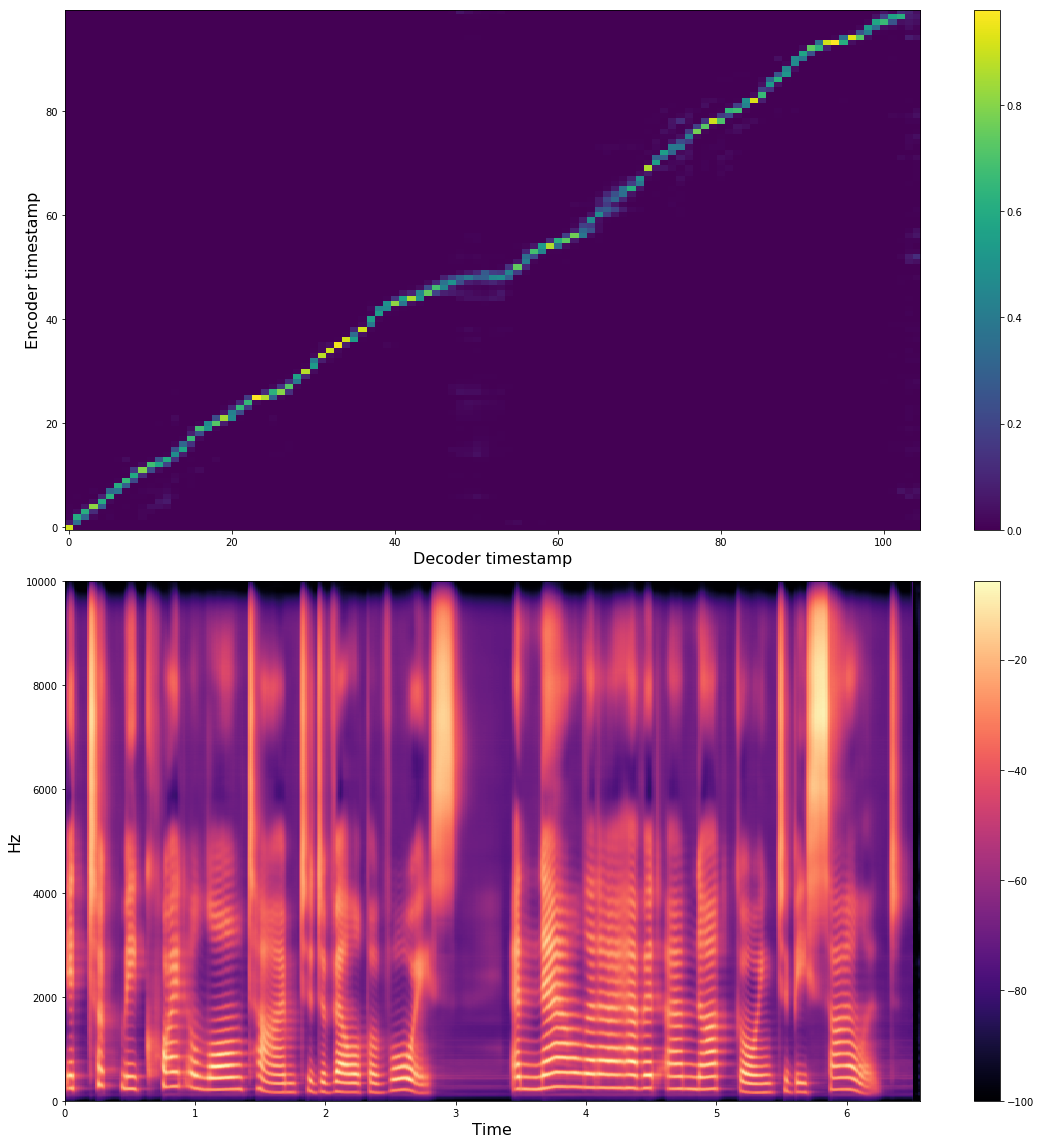

In [7]:
sentence =  "It took me quite a long time to develop a voice, and now that I have it I'm not going to be silent."
model.decoder.max_decoder_steps = 250
alignment = tts(model, sentence, CONFIG, use_cuda, ap)

 >  Run-time: 13.074267864227295


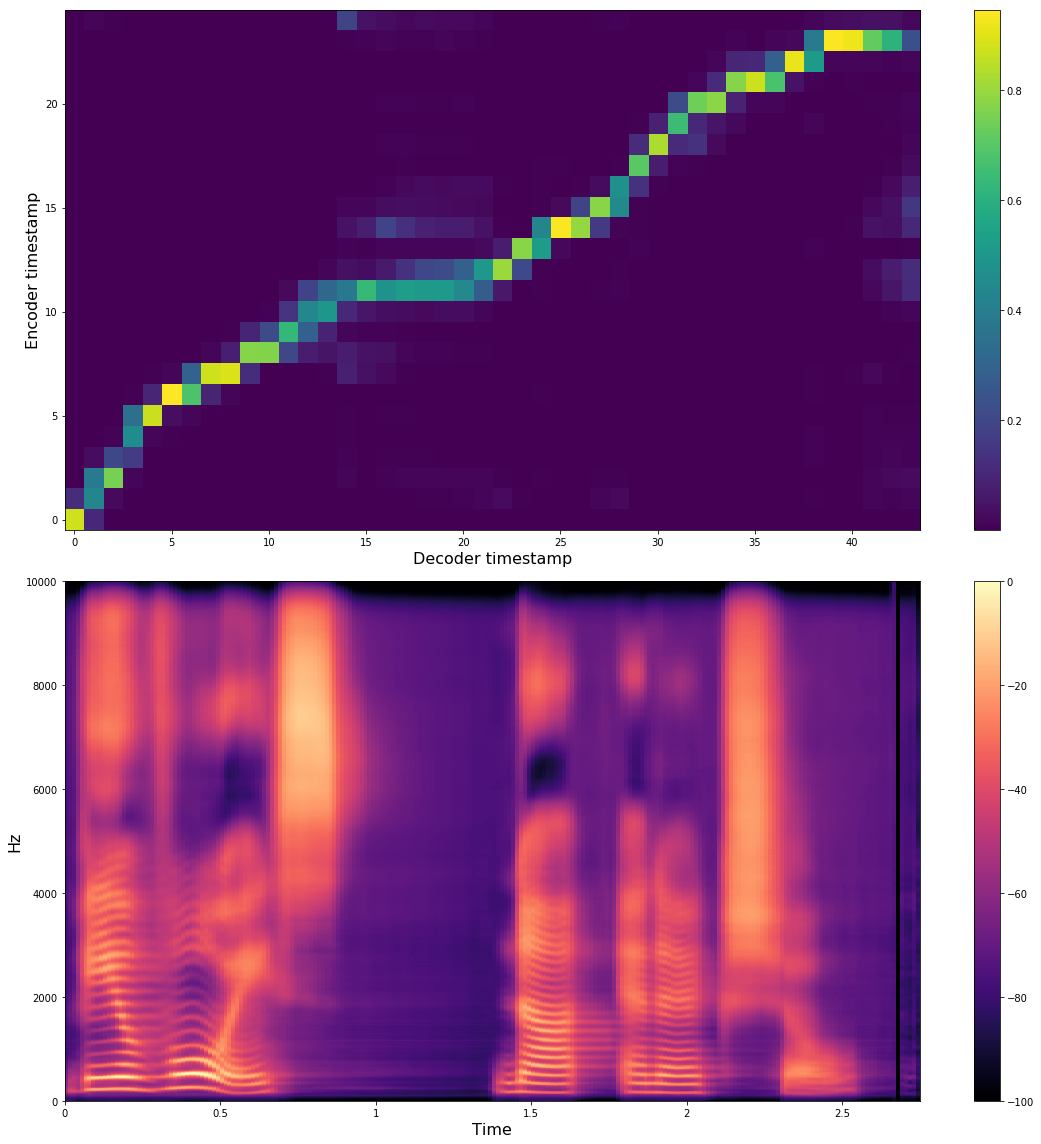

In [8]:
sentence = "Be a voice, not an echo."  # 'echo' is not in training set. 
alignment = tts(model, sentence, CONFIG, use_cuda, ap)

 >  Run-time: 12.174984216690063


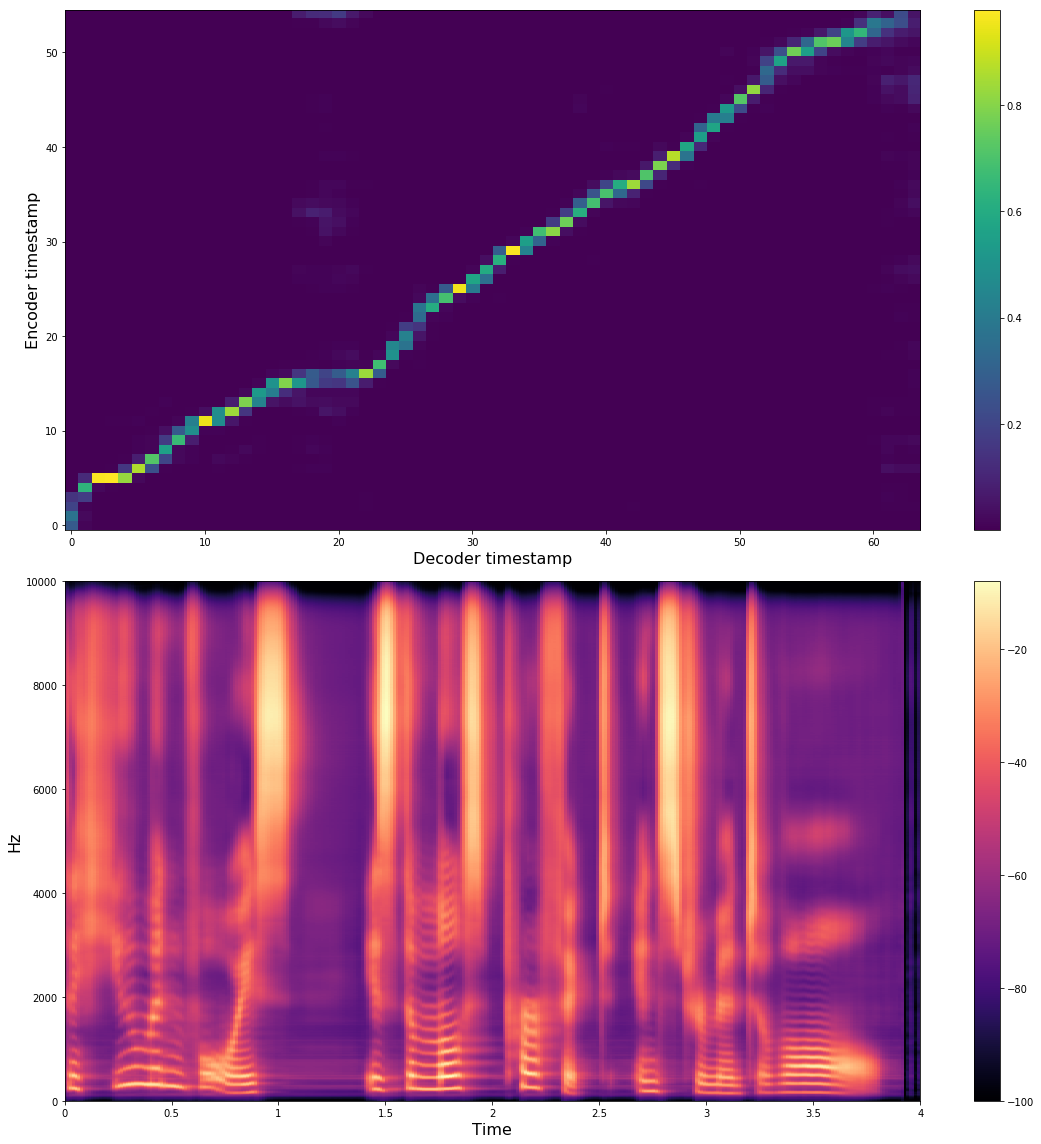

In [27]:
sentence = "The human voice is the most perfect instrument of all."
alignment = tts(model, sentence, CONFIG, use_cuda, ap)

 >  Run-time: 20.04722023010254


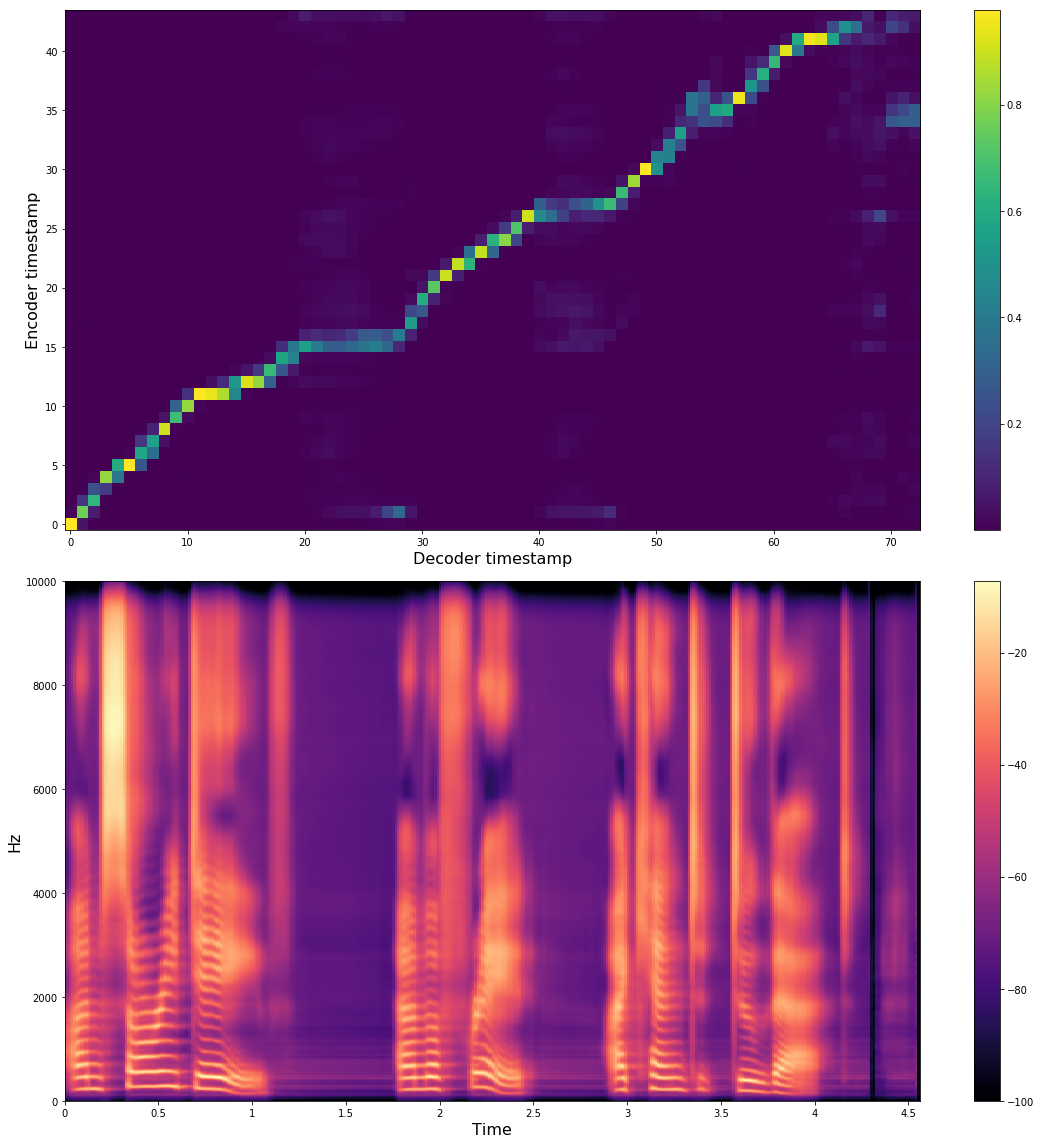

In [28]:
sentence = "I'm sorry Dave. I'm afraid I can't do that."
alignment = tts(model, sentence, CONFIG, use_cuda, ap)

 >  Run-time: 19.729145765304565


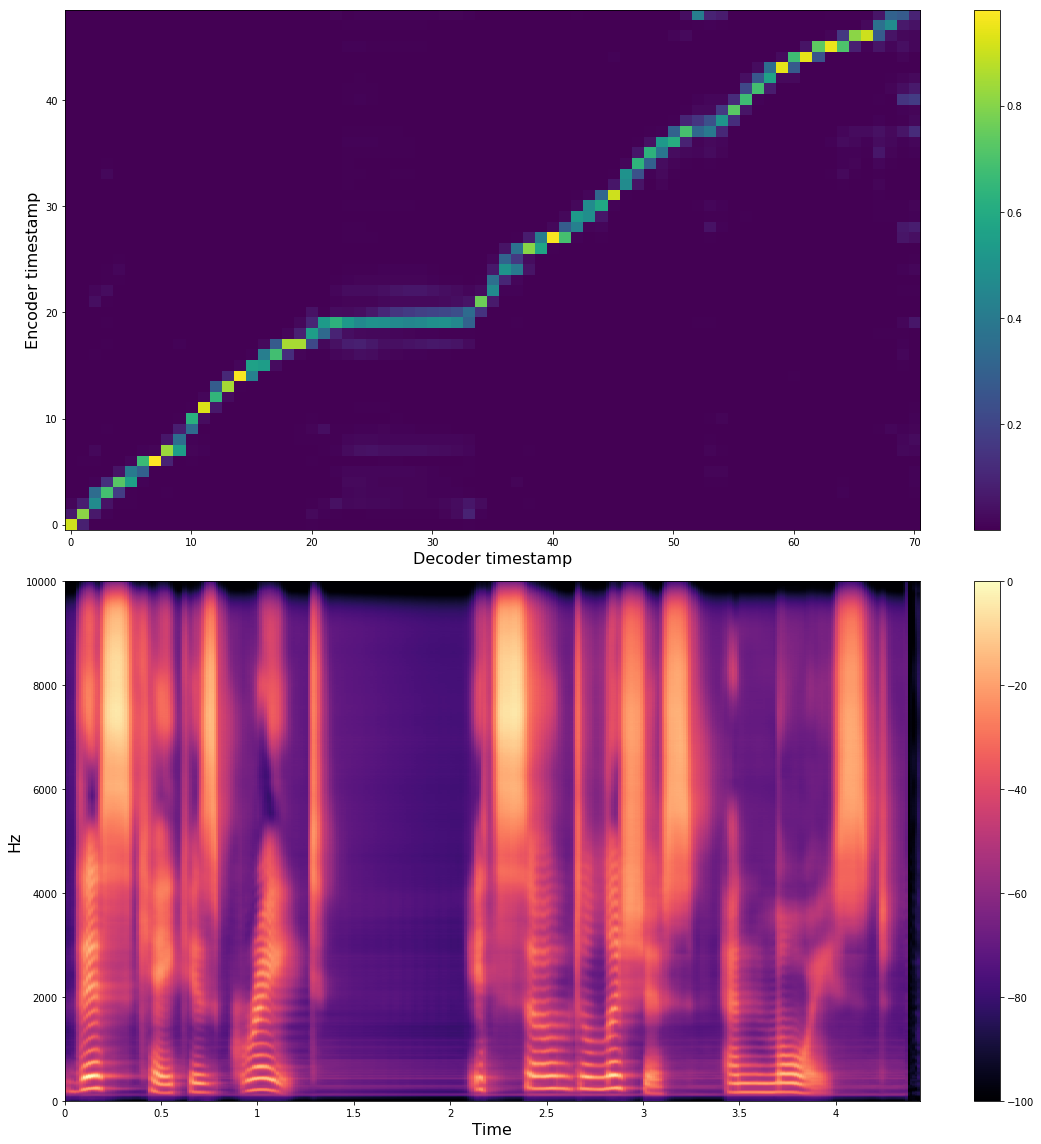

In [34]:
sentence = "This cake is great. It's so delicious and moist."
alignment = tts(model, sentence, CONFIG, use_cuda, ap)